# Semantic Segmentation of Clouds using UNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Dependencies'
These libraries are used to perform semantic segmentation of clouds using UNet.

In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from sklearn.model_selection import KFold
import pandas as pd

This is a chunk of code used to clear RAM in case of memory issues.

In [ ]:
#Clear RAM
import gc
gc.collect()

0

## Configure GPU
To use the maximum capacity of Google Colab, We have to use cloud GPU, In case if you haven't setup GPU, go to runtime type, and add GPU as hardware accelerator.

In [ ]:
device = '/GPU:0' if tf.config.experimental.list_physical_devices('GPU') else '/CPU:0'
print(device)

/GPU:0


## Import Dataset
All operations related to Dataset was performed in this section including importing, exporting, tiling.

### Load presaved dataset
In case if you've already stored data somewhere in google drive, you can load the files here.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ZAIT/DATA/subscenes/S2A_MSIL1C_20180101T010721_N0206_R045_T53HLD_20180101T041600.npy'
X = np.load(path)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ZAIT/DATA/masks/S2A_MSIL1C_20180101T010721_N0206_R045_T53HLD_20180101T041600.npy'
y = np.load(path)

## Perform Tiling on Dataset
Tiling is the concept of breaking your large image into smaller portions in a way that no data is lost. We've performed overlapping tiling with an offset of 0.5 to get desired results.

### Define Limits
These Limits are used to define how many files the program will read, In case of memory issues, user can take a chunk of files by defining the low and high points. Both points represents the file number present in folder.

In [ ]:
low = 0
high= 513 #Total Data files

### Load Masks
In this section, Numpy files of Masks dataset (labels) are loaded from disk.

In [ ]:
def read_masks(folder_path):
    """
    Function to read all .npy files present in a folder and tile them
    """
    images = []
    for count, file in enumerate(os.listdir(folder_path)):
        if file.endswith('.npy') and (count >= low and count < high):
            img = np.load(os.path.join(folder_path, file))
            # Take only cloud channel
            img = tf.convert_to_tensor(img[:, :, 1]) #img shape (1022,1022)
            images.append(img)
    return images

folder_path = '/content/drive/MyDrive/masks'
with tf.device(device):
  masks = read_masks(folder_path)
masks = np.array(masks)

### Load Subscenes
In this section, Numpy files of Subscenes dataset (labels) are loaded from disk

In [ ]:
def read_subscene(folder_path):
    """
    Function to read all .npy files present in a folder and tile them
    """
    images = []
    count= 0
    for file in os.listdir(folder_path):
        if file.endswith('.npy') and (count >= low and count < high):
            img = np.load(os.path.join(folder_path, file))
            img = tf.convert_to_tensor(img, dtype=tf.float32)
            img = tf.concat((img[..., :3], img[..., 7:8]), axis=-1)
            images.append(img)
        count = count+1
    return images


# Read all .npy files present in the folder images and convert them in tiles
folder_path = '/content/drive/MyDrive/subscenes/subscenes'
with tf.device(device):
  subscenes = read_subscene(folder_path)

subscenes = np.array(subscenes)

# Tiling

In [ ]:
# Function to perform tiling on masks provided
def tile_img(img, size, overlap=0.5):
    """
    Function to tile an input image into overlapping tiles
    """
    tiles = []

    if len(img.shape) == 3:
      total, height, width = img.shape
    elif len(img.shape) == 4:
       total, height, width, channel = img.shape
    # Select Tile Size
    tile_h, tile_w = size[:2]
    # Calculate Offset
    offset_h = int(tile_h * overlap)
    offset_w = int(tile_w * overlap)
    for x in range(total):
      for i in range(0, height-tile_h+1, offset_h):
          for j in range(0, width-tile_w+1, offset_w):
            # If its a subscene
            if len(img.shape) == 4:
              tiles.append(img[x, i:i+tile_h, j:j+tile_w, :])

            # If its a mask
            elif len(img.shape) == 3:
              tiles.append(img[x, i:i+tile_h, j:j+tile_w])

    return tiles

### Save Datasets
Once the data is processed and tiled, We can save in google drive

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ZAIT/DATA/subscenes.npy'
np.save(path, X)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/ZAIT/DATA/masks.npy'
np.save(path, y)

## Check Shape of Data
In order to confirm shape of data loaded or processed, We can call these two cells below:

In [ ]:
np.shape(subscenes)

(30, 1022, 1022, 4)

In [ ]:
np.shape(masks)

(30, 1022, 1022)

In [ ]:
# Extract the first three bands (R, G, B)
rgb_data = subscenes[:, :, :, :3]

# Create a subplot with a shape of (2, 10)
fig, axs = plt.subplots(10, 2, figsize=(20, 20))

# Iterate over each image and display the ground truth masks and RGB images
for i in range(subscenes.shape[0]):
    axs[i, 0].imshow(masks[i], cmap=custom_cmap, vmin=0, vmax=1)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Mask {}'.format(i+1))

    axs[i, 1].imshow(rgb_data[i])
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Image {}'.format(i+1))

plt.tight_layout()
plt.show()

## Perform Tiling

In [ ]:
tiles_subscenes = tile_img(subscenes, (384,384,4), 0.5)
tiles_masks = tile_img(masks, (384,384), 0.5)

In [ ]:
print(np.shape(tiles_subscenes))
print(np.shape(tiles_masks))


(480, 384, 384, 4)
(480, 384, 384)


In [ ]:
tiles_subscenes = np.array(tiles_subscenes)
tile_masks = np.array(tiles_masks)

## Data Visualization
Data of Subscenes and Labels in the form of tiles are visualized in this section:

###! Important
Data Will not be visualized if datset is transposed and is processed according to the required shape of model


In [ ]:
# Must RUN ONCE if you need to visualize the data
custom_cmap = ListedColormap(['black', 'white'])

## Build Model
UNet is build in this section.
The original model proposed in the paper do not contain Batch Normalization, but for optimal solution to our problem, we have used Batch Normalization in convolution block of the model used in both encoder and decoder.

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(filters= num_filters, kernel_size= 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters= num_filters, kernel_size= 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(filters= num_filters, kernel_size= (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(filters=1, kernel_size=1, padding="same", activation='sigmoid')(d4)
    #outputs = tf.keras.backend.round(outputs)  # Round the output to 0 or 1
    model = Model(inputs, outputs, name="U-Net")
    return model

segmentation_model = build_unet((384,384,4))

## Load the Model
In case if you already have a pretrained model present in google drive, give a path and load the model in colab.

In [ ]:
path = ('/content/drive/MyDrive/saved_model.pb')
segmentation_model = tf.keras.models.load_model(path)

To print the summary of model: run the following cell:

In [ ]:
segmentation_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Train the Model using K-fold and Perform grid search
The model was trained and evaluated in this process. To find the best performing k value, We've performed grid search.

In [ ]:
  # Train the model
  k = 2
  kf = KFold(n_splits=k)
  histories = []
  with tf.device(device):
      segmentation_model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
      for train_index, val_index in kf.split(tiles_subscenes):
          X_train, X_val = np.stack([tiles_subscenes[i] for i in train_index]), np.stack([tiles_subscenes[i] for i in val_index])
          y_train, y_val = np.stack([tiles_masks[i] for i in train_index]), np.stack([tiles_masks[i] for i in val_index])


          print(np.shape(X_train))
          print(np.shape(X_val))
          print(np.shape(y_train))
          print(np.shape(y_val))

          history = segmentation_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))
          histories.append(history)


## Plot the histories
Plot the loss, accuracy while traininga as well as in validation.

In [ ]:
import pandas as pd

# Create lists to store the metrics per epoch
loss_per_epoch = []
accuracy_per_epoch = []
val_loss_per_epoch = []
val_accuracy_per_epoch = []

# Iterate over the histories and extract metrics per epoch
for history in histories:
    loss_per_epoch.extend(history.history['loss'])
    accuracy_per_epoch.extend(history.history['accuracy'])
    val_loss_per_epoch.extend(history.history['val_loss'])
    val_accuracy_per_epoch.extend(history.history['val_accuracy'])

# Create a dataframe with the metrics per epoch
data = {
    'loss': loss_per_epoch,
    'accuracy': accuracy_per_epoch,
    'val_loss': val_loss_per_epoch,
    'val_accuracy': val_accuracy_per_epoch
}

df = pd.DataFrame(data)

# Print the dataframe
print(df)


       loss  accuracy  val_loss  val_accuracy
0  0.503846  0.733073  0.795991      0.537970
1  0.455613  0.765185  0.620324      0.745844
2  0.421855  0.784889  0.728794      0.713422
3  0.404726  0.795873  1.737527      0.427558
4  0.397389  0.802393  1.377036      0.473293
5  0.378111  0.812000  1.255086      0.814088
6  0.415639  0.795760  1.273197      0.204640
7  0.394154  0.806787  1.241077      0.432008
8  0.407990  0.808695  0.657278      0.486042
9  0.380573  0.821782  0.575584      0.691063


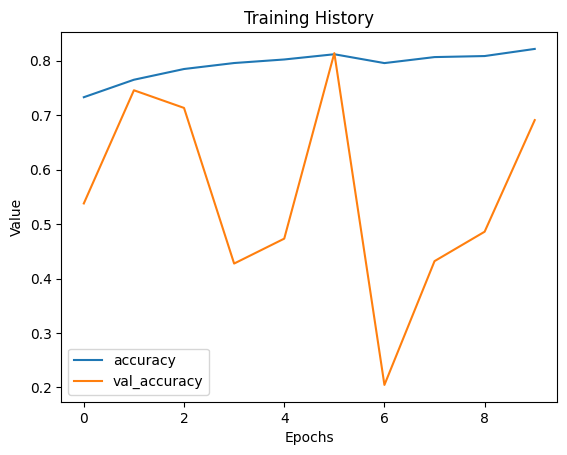

In [ ]:
import matplotlib.pyplot as plt

# Plot the dataframe
df.plot(y=['accuracy', 'val_accuracy'], xlabel='Epochs', ylabel='Value')

# Set the plot title
plt.title('Training History')

# Display the plot
plt.show()


## Save the model
If you're done training your model and its working fine, you can save the model using the following code:

In [ ]:
# Save the trained model for future use
segmentation_model.save('/content/drive/MyDrive/saved_model.pb')

## Convert to ONNX

In [ ]:
import tensorflow as tf
import tf2onnx
import onnx
import onnxruntime as rt

In [ ]:
input_signature = [tf.TensorSpec([None, 224,224,4], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(segmentation_model, input_signature, opset=13)
onnx.save(onnx_model, "model.onnx")

# Check Working of ONNX model

In [ ]:
session = rt.InferenceSession("model.onnx")
# Get the input tensor's name and shape
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape

# Generate a sample input tensor
input_data = np.expand_dims(tiles_subscenes[68], axis=0).astype(np.float32)

# Run inference and get the output tensor
output = session.run(None, {input_name: input_data})[0]
# Post process
result = output[0].squeeze()
plt.imshow(result, cmap=custom_cmap, vmin=0, vmax=1)